In [18]:
import json
import functools
import operator
from typing import List, Dict, Any
import os
import re
from PIL import Image, ImageDraw, ImageFont, ImageEnhance
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import plotly.graph_objects as go
from tqdm import tqdm

import pytesseract
from pytesseract import Output
from typing import List, Dict, Any

import easyocr
from sklearn.model_selection import train_test_split

In [17]:
id = '00040534'
image_path = f'intelligent-text-extraction/train/images/{id}.png'
with open(f'intelligent-text-extraction/train/annotations/{id}.json', 'r') as f:
    annotation = json.load(f)
image = Image.open(image_path)



In [19]:

def preprocess_image(image_path: str):
    """
    Charge et prétraite l'image pour améliorer la reconnaissance du texte.
    - Conversion en niveaux de gris
    - Égalisation d'histogramme
    - Seuillage automatique pour obtenir une image binaire
    """
    image = cv2.imread(image_path)
    # Conversion en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Amélioration du contraste avec égalisation d'histogramme
    equalized = cv2.equalizeHist(gray)
    # Seuillage automatique avec Otsu
    _, thresh = cv2.threshold(equalized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh

In [34]:

def analyze_image_tesseract(image_path: str, lang: str = 'eng') -> List:
    """
    Analyse l'image en utilisant Tesseract et retourne une liste de tuples contenant :
    - Les coordonnées de la bounding box sous la forme [[x_min, y_min], [x_max, y_max]]
    - Le texte détecté
    - La confiance (score)
    """
    # Prétraiter l'image pour améliorer l'OCR
    # processed_image = preprocess_image(image_path)
    processed_image = cv2.imread(image_path)
    
    # Configurer Tesseract (OEM et PSM peuvent être ajustés selon le type d'image)
    custom_config = r'--oem 3 --psm 6'
    
    # Obtenir les résultats sous forme de dictionnaire
    data = pytesseract.image_to_data(processed_image, output_type=Output.DICT, config=custom_config, lang=lang)
    
    results = []
    n_boxes = len(data['level'])
    for i in range(n_boxes):
        # Filtrer les résultats avec une confiance positive et un texte non vide
        if int(data['conf'][i]) > 0 and data['text'][i].strip() != "":
            x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
            # Construire la boîte englobante : on prend le point supérieur gauche et inférieur droit
            bbox = [[x, y], [x + w, y + h]]
            text = data['text'][i]
            conf = float(data['conf'][i])
            results.append((bbox, text, conf))
    return results

In [21]:
def analyze_image(image_path:str, language:str='en') -> list:
    """
    Analyze the image to detect text using EasyOCR.

    Parameters:
    image_path (str): The path to the image file.

    Returns:
    list: A list of tuples containing the bounding box, detected text, and confidence score for each detected text region.
    """
    # Create a Reader object for text detection
    reader = easyocr.Reader([language], gpu=True)  # You can activate/deactivate GPU
    
    # Read the text from the image
    resultats = reader.readtext(image_path)
    
    return resultats

In [22]:
def transform_result(results: List[Dict[str, Any]]) -> str:
    """
    Transforms OCR results into Challenge's JSON format.

    Args:
        results (List[Dict[str, Any]]): A list of OCR results where each result is a dictionary containing:
            - bbox (List[List[int]]): Bounding box coordinates.
            - text (str): Detected text.
            - prob (float): Confidence score.

    Returns:
        str: A JSON string representing the transformed OCR results.
    """
    form_data = []
    for idx, (bbox, text, prob) in enumerate(results):
        # Convert bounding box coordinates to integers
        bbox = [[int(coord) for coord in point] for point in bbox]
        box_extracted = [bbox[0], bbox[2]]
        flat_box = [coord for sublist in box_extracted for coord in sublist]
        
        # Create the structure for each element
        item = {
            "box": flat_box,
            "text": text,
            "label": "RF",  #### WARNING : Customize this field as needed !
            "words": [{"box": flat_box, "text": text}],  # Each word is encapsulated in a 'words' list
            "linking": [],  # This part can be used to link words if necessary
            "id": idx
        }
        
        form_data.append(item)

    # Convert to JSON
    json_data = {
        "form": form_data
    }

    # Convert JSON data to a formatted string
    #json_output = json.dumps(json_data, indent=4, ensure_ascii=False)
    return json_data

In [30]:
def transform_result_tesseract(results: list) -> dict:
    """
    Transforme les résultats de Tesseract en format JSON d'annotations.
    Chaque élément est annoté avec le label "RF" (modifiable selon vos besoins).
    Pour Tesseract, le bbox est au format [[x, y], [x+w, y+h]].
    """
    form_data = []
    for idx, (bbox, text, conf) in enumerate(results):
        # Pour Tesseract, le bbox contient deux points :
        # Le point supérieur gauche : [x, y]
        # Le point inférieur droit : [x+w, y+h]
        flat_box = [bbox[0][0], bbox[0][1], bbox[1][0], bbox[1][1]]
        item = {
            "box": flat_box,
            "text": text,
            "label": "RF",  # Vous pouvez modifier ce label selon vos besoins
            "words": [{"box": flat_box, "text": text}],
            "linking": [],
            "id": idx
        }
        form_data.append(item)
    return {"form": form_data}


In [28]:
def draw_boxes(image:Image, annotation:dict) -> Image:
    # Create a drawing context
    image_with_boxes = image.copy()
    draw = ImageDraw.Draw(image_with_boxes)

    # Load a font
    system_fonts = fm.findSystemFonts(fontpaths=None, fontext='ttf')    
    sans_serif_font = next((f for f in system_fonts if 'sans' in f.lower()), None)
    
    if sans_serif_font:
        font = ImageFont.truetype(sans_serif_font, 30)
    else:
        print("No suitable font found, using default")
        font = ImageFont.load_default()

    for dict_box in annotation['form']:
        text = dict_box['text']
        (x_min, y_min, x_max, y_max) = dict_box['box']
        if x_min < x_max and y_min< y_max:
            # Draw rectangle
            draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)
            # Add text
            draw.text((x_min, y_min - 30), f"{text}", fill="blue", font=font)
        else:
            print(f"Bounding box is invalid: {dict_box['box']}")
    return image_with_boxes

In [24]:
# Define a function to draw boxes only if the label correspond to the input
def draw_specific_boxes(image:Image, annotation:dict, specific_label:str) -> Image:
    # Create a drawing context
    image_with_boxes = image.copy()
    draw = ImageDraw.Draw(image_with_boxes)

    # Load a font
    system_fonts = fm.findSystemFonts(fontpaths=None, fontext='ttf')    
    sans_serif_font = next((f for f in system_fonts if 'sans' in f.lower()), None)
    
    if sans_serif_font:
        font = ImageFont.truetype(sans_serif_font, 30)
    else:
        print("No suitable font found, using default")
        font = ImageFont.load_default()

    for dict_box in annotation['form']:
        label = dict_box['label']
        if label == specific_label:
            text = dict_box['text']
            (x_min, y_min, x_max, y_max) = dict_box['box']
            if x_min < x_max and y_min< y_max:
                # Draw rectangle
                draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)
                # Add text
                draw.text((x_min, y_min - 30), f"{text}", fill="blue", font=font)
            else:
                print(f"Bounding box is invalid: {dict_box['box']}")
    return image_with_boxes

{'form': [{'box': [1090, 40, 1210, 104], 'text': 'TEP', 'label': 'RF', 'words': [{'box': [1090, 40, 1210, 104], 'text': 'TEP'}], 'linking': [], 'id': 0}, {'box': [1209, 40, 1369, 104], 'text': 'MiVe', 'label': 'RF', 'words': [{'box': [1209, 40, 1369, 104], 'text': 'MiVe'}], 'linking': [], 'id': 1}, {'box': [1183, 248, 1399, 300], 'text': 'ACUTE', 'label': 'RF', 'words': [{'box': [1183, 248, 1399, 300], 'text': 'ACUTE'}], 'linking': [], 'id': 2}, {'box': [1430, 248, 1740, 300], 'text': 'TOXICITY', 'label': 'RF', 'words': [{'box': [1430, 248, 1740, 300], 'text': 'TOXICITY'}], 'linking': [], 'id': 3}, {'box': [1773, 249, 1840, 299], 'text': 'IN', 'label': 'RF', 'words': [{'box': [1773, 249, 1840, 299], 'text': 'IN'}], 'linking': [], 'id': 4}, {'box': [1875, 248, 2037, 299], 'text': 'MICE', 'label': 'RF', 'words': [{'box': [1875, 248, 2037, 299], 'text': 'MICE'}], 'linking': [], 'id': 5}, {'box': [345, 449, 530, 475], 'text': 'compouno', 'label': 'RF', 'words': [{'box': [345, 449, 530, 475

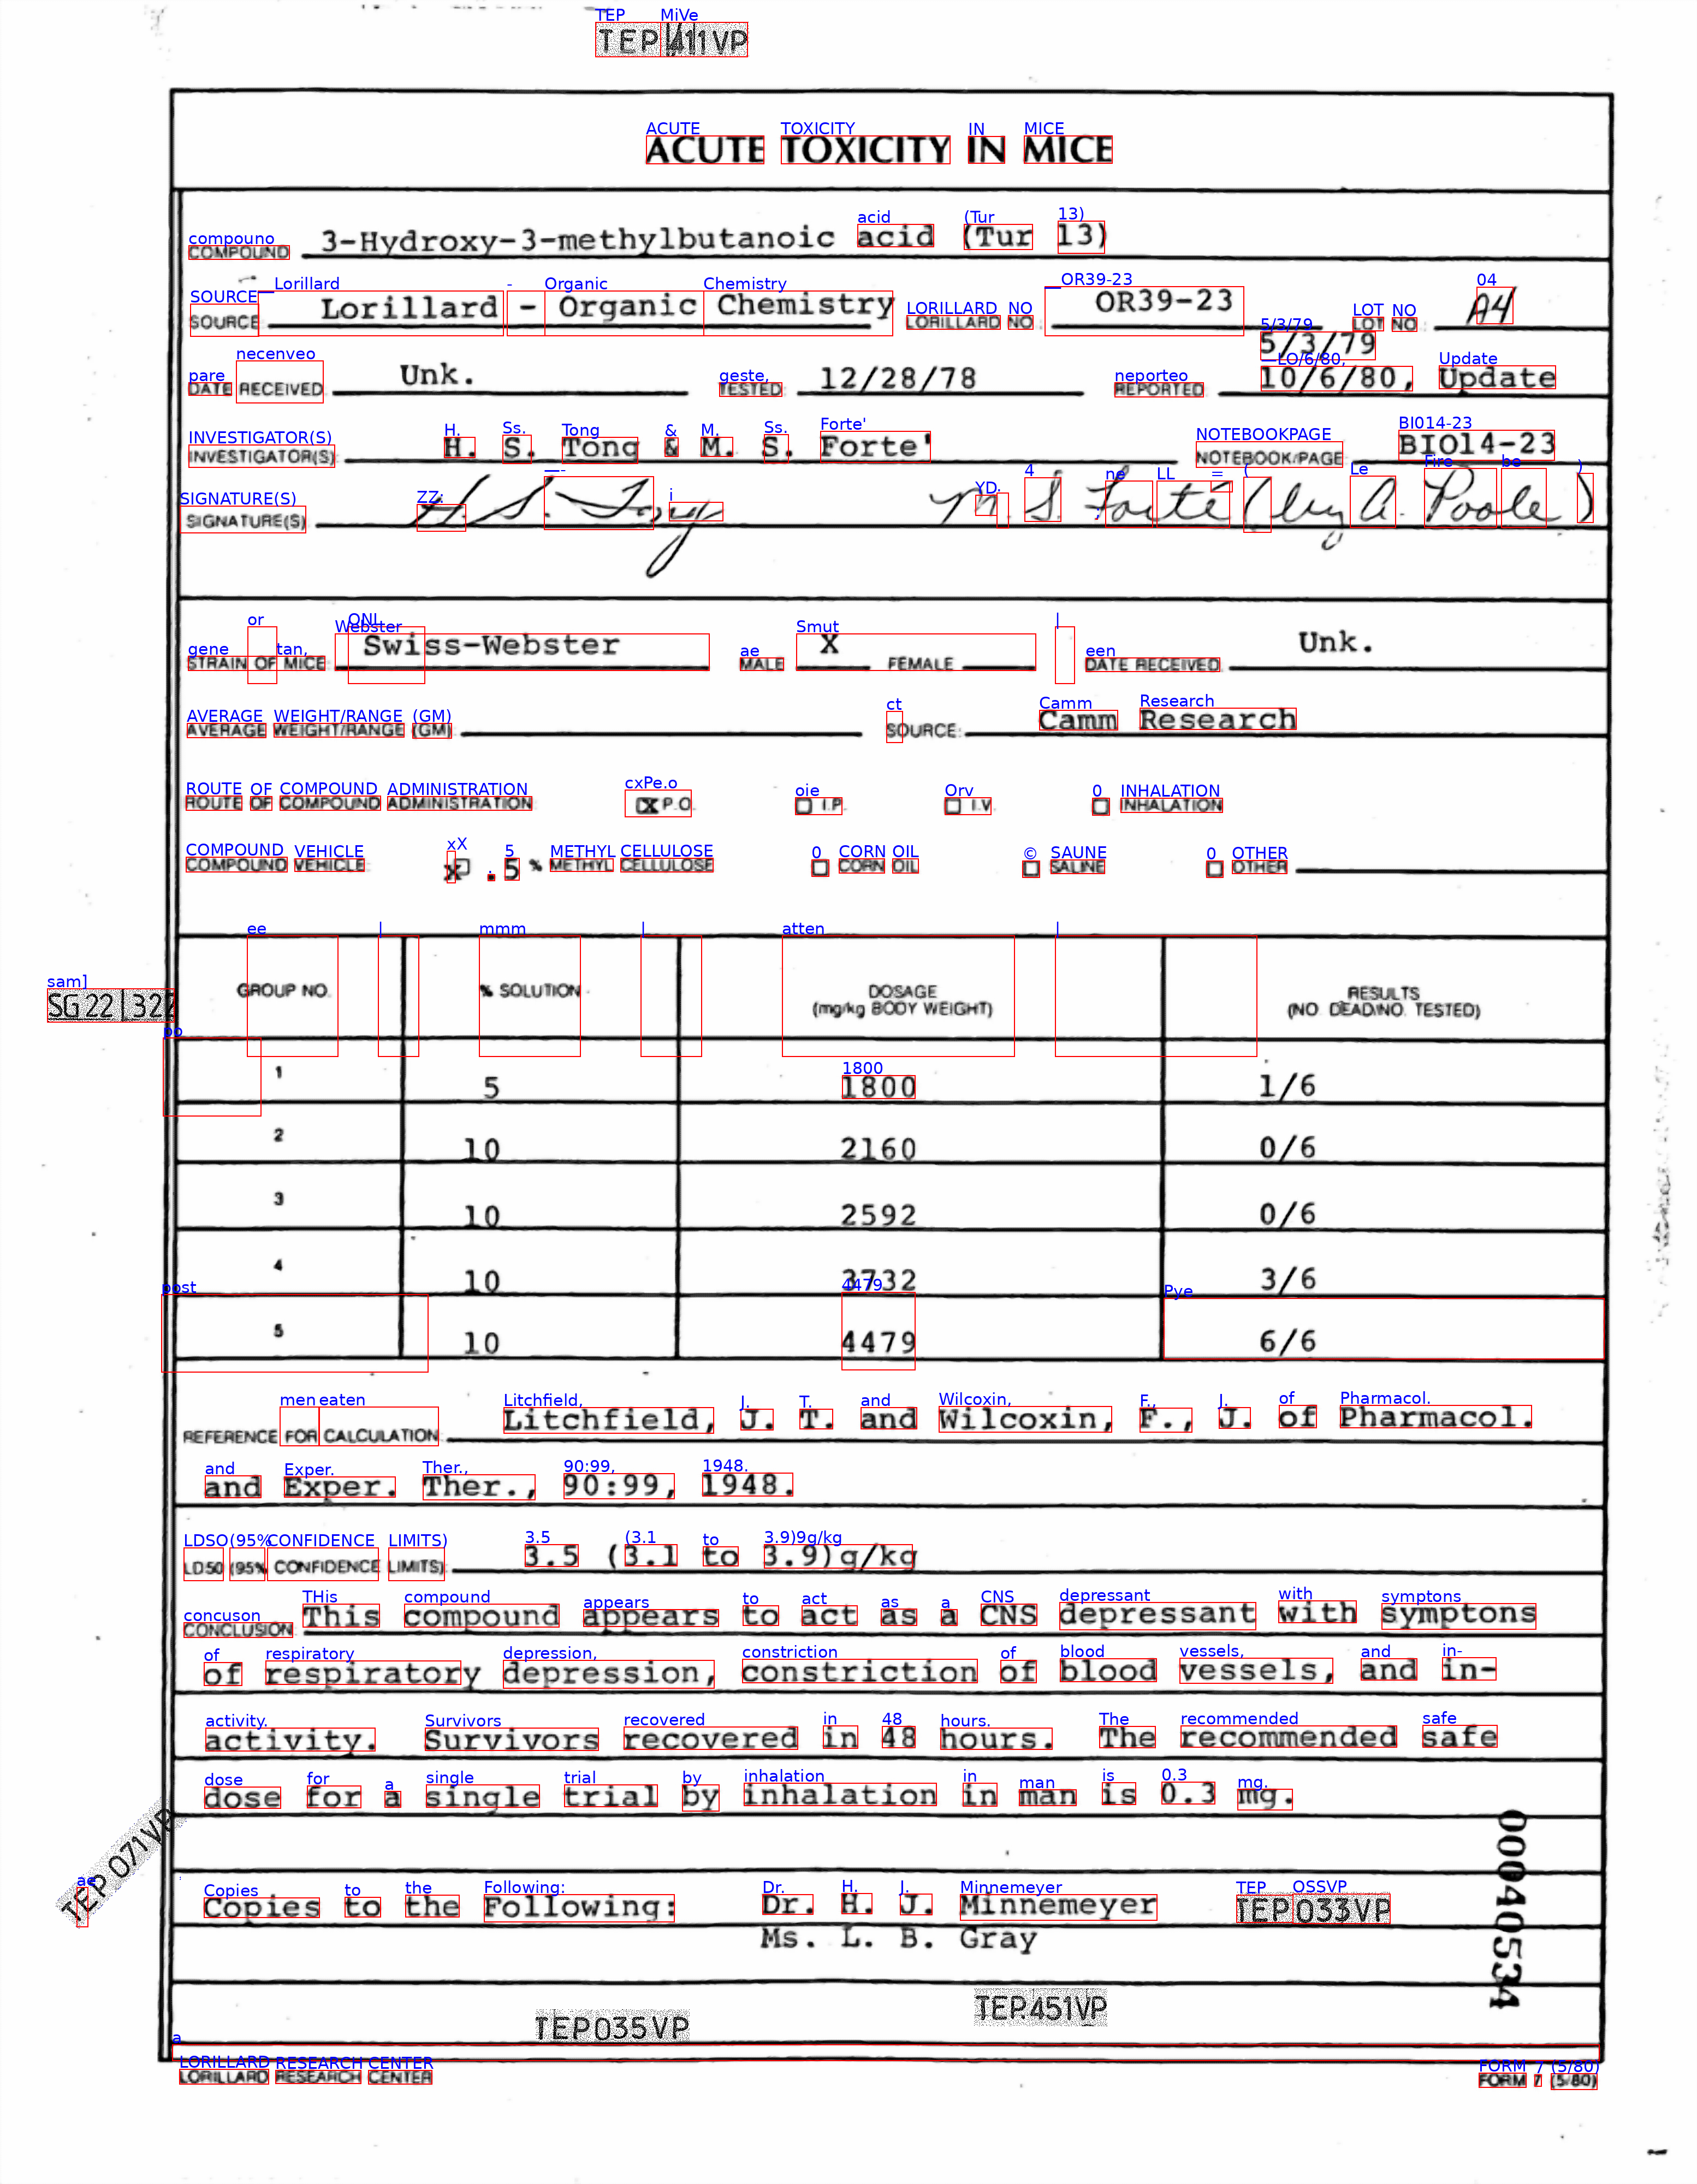

In [35]:
results = transform_result_tesseract(analyze_image_tesseract(image_path))
print(results)
draw_boxes(image, results)